### Notebook to deploy trained random forest regression model to predict diatom carbon biomass

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import xarray as xr

from sklearn.ensemble import RandomForestRegressor

# library for save and load scikit-learn models
import pickle

In [3]:
ls trained_models/

random_forest.pickle          random_forest.pickle_histGB
random_forest.pickle_chl_sst  random_forest.pickle_noLat


In [4]:
# load pre-trained model - Chla and SST are model inputs; Diatom Carbon is model output (target)
filename = "trained_models/random_forest.pickle_chl_sst"

loaded_model = pickle.load(open(filename, "rb"))

In [7]:
#ds = xr.open_dataset('A20161372016144.L3m_8D_CHL_chlor_a_4km.nc') 

In [5]:
# satellite chl informtation
chl_ds = xr.open_dataset('sat_data/AQUA_MODIS.20160516_20160523.L3m.8D.CHL.chlor_a.4km.nc')

In [6]:
chl_ds.chlor_a

<xarray.DataArray 'chlor_a' (lat: 4320, lon: 8640)>
[37324800 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 89.98 89.94 89.9 89.85 ... -89.85 -89.9 -89.94 -89.98
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0

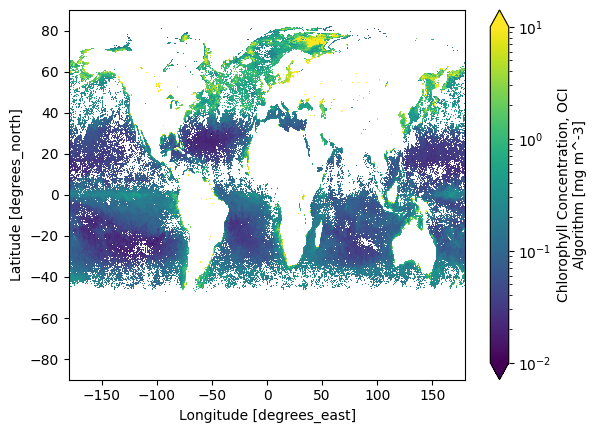

In [7]:
chl_ds.chlor_a.plot(x="lon",  norm=LogNorm(vmin=0.01, vmax=10));

In [10]:
# estimate diatom carbon biomass using a previous method
baseline_diats = 1.5*chl_ds.chlor_a**1.9  # Eq. from Chase et al. 2022

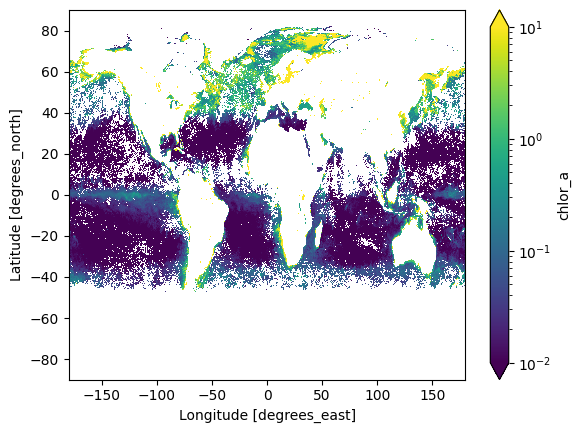

In [11]:
baseline_diats.plot(x="lon",  norm=LogNorm(vmin=0.01, vmax=10));

In [12]:
# load satellite SST data (do not use bbp for now)
sst_ds = xr.open_dataset('sat_data/AQUA_MODIS.20160516_20160523.L3m.8D.SST.sst.4km.nc')
#bbp_ds = xr.open_dataset('sat_data/AQUA_MODIS.20160516_20160523.L3m.8D.IOP.bbp_443.4km.nc')

In [13]:
sst_ds

<xarray.Dataset>
Dimensions:   (lat: 4320, lon: 8640, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 89.98 89.94 89.9 89.85 ... -89.9 -89.94 -89.98
  * lon       (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    sst       (lat, lon) float32 ...
    qual_sst  (lat, lon) float32 ...
    palette   (rgb, eightbitcolor) uint8 ...
Attributes: (12/61)
    product_name:                     AQUA_MODIS.20160516_20160523.L3m.8D.SST...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    temporal_range:                   8-day
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Optics >...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        16908859
    data_minimum:                     -1.8
    data_maximum:                     39.985

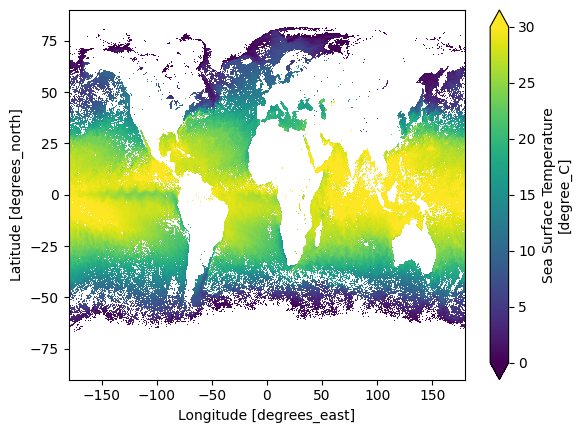

In [14]:
sst_ds.sst.plot(x="lon", vmin=0, vmax=30)

In [ ]:
#bbp_ds

In [ ]:
#bbp_ds.bbp_443.plot(x='lon', vmin=0, vmax=0.01)

In [15]:
# concatenate the two datasets of variables into one dataset
ds = xr.merge([chl_ds,sst_ds], compat='override')  #,bbp_ds

In [16]:
ds

<xarray.Dataset>
Dimensions:   (lat: 6811, lon: 13674, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 -89.98 -89.98 -89.94 -89.9 ... 89.9 89.9 89.94 89.98
  * lon       (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    palette   (rgb, eightbitcolor) uint8 ...
    sst       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    qual_sst  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20160516_20160523.L3m.8D.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        12142689
    data_minimum:                     0.0024211504
    data_maximum:                     86.086975

In [17]:
data_sst = ds['sst'].values  #,'chlor_a','bbp_443'
# Reshape the 2D variable into a 2D NumPy array
sst_reshaped = data_sst.reshape(-1, data_sst.shape[-1])

data_chla = ds['chlor_a'].values  #,'chlor_a','bbp_443'
# Reshape the 2D variable into a 2D NumPy array
chla_reshaped = data_chla.reshape(-1, data_chla.shape[-1])

data_bbp = ds['bbp_443'].values  #,'chlor_a','bbp_443'
# Reshape the 2D variable into a 2D NumPy array
bbp_reshaped = data_bbp.reshape(-1, data_bbp.shape[-1])

In [20]:
lats = abs(ds.lat.to_numpy())
sst = ds.sst.to_numpy()
chla = ds.chlor_a.to_numpy()
#bbp = ds.bbp_443.to_numpy()

In [ ]:
# repeat the latitude array so that it is the same size as the variable arrays
#lat = np.repeat(lats[np.newaxis], 13674)
#lat

In [22]:
#lat = lat.flatten()
sst = sst.flatten()
chla = chla.flatten()
#bbp = bbp.flatten()

In [24]:
sst.shape

(93133614,)

In [25]:
chla.shape

(93133614,)

In [26]:
inputs = np.dstack((sst,chla)) #lat,,bbp

In [27]:
inputs.shape

(1, 93133614, 2)

In [28]:
inputs = np.squeeze(inputs)

In [29]:
inputs.shape

(93133614, 2)

In [53]:
test = pd.DataFrame(inputs)
test.describe()

,0,1
count,1.690886e+07,1.214269e+07
mean,1.923671e+01,4.725673e-01
std,9.569515e+00,1.888570e+00
min,-1.800000e+00,2.421150e-03
25%,1.114000e+01,5.294751e-02
50%,2.212500e+01,1.030986e-01
75%,2.753500e+01,2.334667e-01
max,3.998500e+01,8.608698e+01


In [31]:
# store dropped rows in a different data frame
dropped_rows = test[test.isna().any(axis=1)]
cleaned_df = test.dropna()

In [32]:
# predict diatoms using the pre-trained sklearn RF model
pred = loaded_model.predict(cleaned_df)

/Users/alisonchase/miniconda3/envs/diatoms/lib/python3.12/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but RandomForestRegressor was fitted with feature names
  warnings.warn(
/Users/alisonchase/miniconda3/envs/diatoms/lib/python3.12/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/Users/alisonchase/miniconda3/envs/diatoms/lib/python3.12/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/Users/alisonchase/miniconda3/envs/diatoms/lib/python3.12/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, p

In [33]:
pred = pd.DataFrame(pred)

In [34]:
dropped_rows

,0,1
0,NaN,NaN
1,NaN,NaN
2,NaN,NaN
3,NaN,NaN
4,NaN,NaN
...,...,...
93133609,NaN,NaN
93133610,NaN,NaN
93133611,NaN,NaN
93133612,NaN,NaN


In [35]:
foo = dropped_rows[0]
foo.shape

(91551693,)

In [36]:
# add dropped rows back to the dataframe with indexing preserved
pred_df = pd.concat([pred, dropped_rows[0]], ignore_index=False)

In [54]:
# attempt to recover orginal order (indicies) of rows of data
sorted_df = pred_df.sort_index()

In [38]:
sorted_df = np.squeeze(sorted_df)
sorted_df.shape

(93133614,)

In [39]:
foo = sorted_df.to_numpy()

In [40]:
foo.shape

(93133614,)

In [41]:
# re-shape to put back to 2D grid for map plotting
diat = np.reshape(foo, (6811, 13674))

In [42]:
diat.shape

(6811, 13674)

In [43]:
ds

<xarray.Dataset>
Dimensions:   (lat: 6811, lon: 13674, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 -89.98 -89.98 -89.94 -89.9 ... 89.9 89.9 89.94 89.98
  * lon       (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    palette   (rgb, eightbitcolor) uint8 ...
    sst       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    qual_sst  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20160516_20160523.L3m.8D.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        12142689
    data_minimum:                     0.0024211504
    data_maximum:                     86.086975

In [44]:
diatx = xr.DataArray(diat)

In [45]:
diatx

<xarray.DataArray (dim_0: 6811, dim_1: 13674)>
array([[1.28460448,        nan, 7.54872499, ..., 3.58441588,        nan,
        3.7726501 ],
       [       nan, 3.47770661,        nan, ..., 7.09467795,        nan,
        8.34889822],
       [       nan, 3.23032354,        nan, ..., 4.48554601, 0.90292295,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Dimensions without coordinates: dim_0, dim_1

In [46]:
# copy attribute from chla variable to use the same lat/lon for diatoms
test = ds.chlor_a.copy(data=diatx)

In [47]:
test = test.rename('diat')

In [48]:
test

<xarray.DataArray 'diat' (lat: 6811, lon: 13674)>
array([[1.28460448,        nan, 7.54872499, ..., 3.58441588,        nan,
        3.7726501 ],
       [       nan, 3.47770661,        nan, ..., 7.09467795,        nan,
        8.34889822],
       [       nan, 3.23032354,        nan, ..., 4.48554601, 0.90292295,
               nan],
       ...,
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan],
       [       nan,        nan,        nan, ...,        nan,        nan,
               nan]])
Coordinates:
  * lat      (lat) float32 -89.98 -89.98 -89.94 -89.9 ... 89.9 89.9 89.94 89.98
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Attributes:
    long_name:      Chlorophyll Concentration, OCI Algorithm
    units:          mg m^-3
    standard_name:  mass_concentration_of_chlorophyll_in_sea_water
    valid_min:      0.001
    valid_max:      100.0
    reference:      Hu, C., Lee Z., and Franz, B.A. (2012). Chlorophyll-a alg...
    display_scale:  log
    display_min:    0.01
    display_max:    20.0

In [50]:
ds = ds.assign(diat=test)

In [51]:
ds

<xarray.Dataset>
Dimensions:   (lat: 6811, lon: 13674, rgb: 3, eightbitcolor: 256)
Coordinates:
  * lat       (lat) float32 -89.98 -89.98 -89.94 -89.9 ... 89.9 89.9 89.94 89.98
  * lon       (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
Dimensions without coordinates: rgb, eightbitcolor
Data variables:
    chlor_a   (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    palette   (rgb, eightbitcolor) uint8 ...
    sst       (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    qual_sst  (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    diat      (lat, lon) float64 1.285 nan 7.549 nan 8.018 ... nan nan nan nan
Attributes: (12/62)
    product_name:                     AQUA_MODIS.20160516_20160523.L3m.8D.CHL...
    instrument:                       MODIS
    title:                            MODISA Level-3 Standard Mapped Image
    project:                          Ocean Biology Processing Group (NASA/GS...
    platform:                         Aqua
    source:                           satellite observations from MODIS-Aqua
    ...                               ...
    cdm_data_type:                    grid
    keywords:                         Earth Science > Oceans > Ocean Chemistr...
    keywords_vocabulary:              NASA Global Change Master Directory (GC...
    data_bins:                        12142689
    data_minimum:                     0.0024211504
    data_maximum:                     86.086975

#### here i try plotted the estimated diatom carbon, but something is wrong; there should at least be white where all the land is, as we see in the above satellite images.


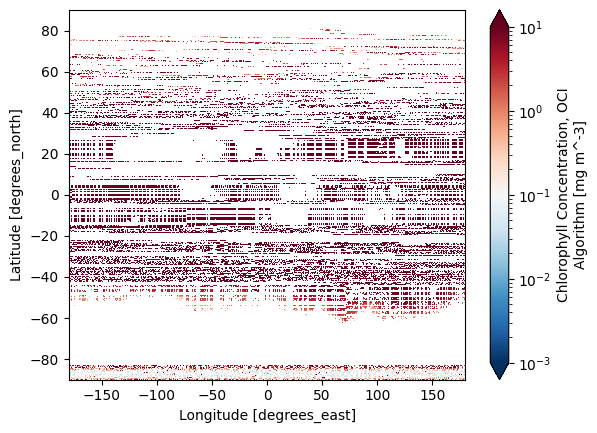

In [52]:
ds.diat.plot(x="lon",  norm=LogNorm(vmin=0.001, vmax=10))

In [ ]:
# use wrappers to combine sklearn and xarray
from sklearn_xarray import wrap

In [ ]:

# Create a sample DataFrame
data = {'A': [1, 2, np.nan, 4],
        'B': [5, np.nan, np.nan, 8],
        'C': [9, 10, 11, 12]}
df = pd.DataFrame(data)

# Step 1: Remove Rows with NaN Values
df_without_nan = df.dropna()

# Step 2: Store Removed Rows
nan_mask = df.isna().any(axis=1)
removed_rows = df[nan_mask].copy()

# Step 3: Add Removed Rows Back
df_with_nan_restored = pd.concat([df_without_nan, removed_rows])

print(df_with_nan_restored)


In [ ]:
sorted_df = df_with_nan_restored.sort_index()

In [ ]:
sorted_df